In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, display
import tabulate
import re
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
api_data = pd.read_csv("../../data/api_data.csv")

print(f"CSV has {len(api_data)} projects.")

CSV has 2731 projects.


In [3]:
api_data

,id,project,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,isFork,deleteBranchOnMerge,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,3518171,sebastianbenz/Jnario,NaN,10372,False,sebastianbenz/Jnario,/sebastianbenz/Jnario,133.0,False,False,...,146.0,35.0,0.0,19.0,32.0,37.0,1303.0,9.0,19.0,20.0
1,3661343,CCI-MIT/XCoLab,NaN,6889,False,CCI-MIT/XCoLab,/CCI-MIT/XCoLab,15.0,False,False,...,9.0,288.0,0.0,8.0,10.0,10.0,10045.0,25.0,97.0,0.0
2,2524488,apache/accumulo,NaN,5141,False,apache/accumulo,/apache/accumulo,864.0,False,False,...,628.0,1394.0,0.0,88.0,333.0,351.0,10876.0,131.0,3.0,38.0
3,65885,android/platform_frameworks_base,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,False,False,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
4,1006053,TeamDev-Ltd/OpenFaces,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,False,False,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,3467722,pingpongboss/Phone-Modem,NaN,1,False,pingpongboss/Phone-Modem,/pingpongboss/Phone-Modem,30.0,False,False,...,0.0,0.0,0.0,5.0,9.0,9.0,24.0,2.0,1.0,0.0
2727,3468682,htdvisser/Skt,NaN,1,True,htdvisser/Skt,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2728,2130242,justjoheinz/STLDroid,NaN,1,False,justjoheinz/STLDroid,/justjoheinz/STLDroid,10.0,False,False,...,1.0,0.0,0.0,1.0,4.0,4.0,24.0,1.0,1.0,5.0
2729,3355503,SpoutDev/BukkitBridge,NaN,1,False,SpoutDev/BukkitBridge,/SpoutDev/BukkitBridge,19.0,False,False,...,0.0,53.0,0.0,17.0,9.0,9.0,248.0,21.0,1.0,0.0


In [4]:
conflicting_merges_per_project = pd.read_csv("../../data/number_conflicting_merges_project_selected.csv")
conflicting_merges_per_project

,id,project,nr_conflicting_merges
0,65885,android/platform_frameworks_base,3355
1,185026,freenet/fred,237
2,206437,apache/directory-server,18
3,217482,Ramblurr/Anki-Android,155
4,223355,alexo/wro4j,395
5,507775,elastic/elasticsearch,235
6,726492,getrailo/railo,163
7,762119,atlasapi/atlas,418
8,961036,hibernate/hibernate-orm,27
9,1006053,TeamDev-Ltd/OpenFaces,178


In [5]:
merges_per_project = pd.read_csv("../../data/number_merges_project_selected.csv")
merges_per_project

,id,project,nr_merges
0,65885,android/platform_frameworks_base,156732
1,185026,freenet/fred,1076
2,206437,apache/directory-server,50
3,217482,Ramblurr/Anki-Android,952
4,223355,alexo/wro4j,1458
5,507775,elastic/elasticsearch,2442
6,726492,getrailo/railo,671
7,762119,atlasapi/atlas,2284
8,961036,hibernate/hibernate-orm,152
9,1006053,TeamDev-Ltd/OpenFaces,611


In [6]:
merges_csv = pd.merge(merges_per_project, conflicting_merges_per_project, on='project', how='inner')
merges_csv = merges_csv.drop(columns=['id_y'])
merges_csv = merges_csv.rename(columns={'id_x':'id'})
merges_csv

,id,project,nr_merges,nr_conflicting_merges
0,65885,android/platform_frameworks_base,156732,3355
1,185026,freenet/fred,1076,237
2,206437,apache/directory-server,50,18
3,217482,Ramblurr/Anki-Android,952,155
4,223355,alexo/wro4j,1458,395
5,507775,elastic/elasticsearch,2442,235
6,726492,getrailo/railo,671,163
7,762119,atlasapi/atlas,2284,418
8,961036,hibernate/hibernate-orm,152,27
9,1006053,TeamDev-Ltd/OpenFaces,611,178


In [7]:
selected_dataset_2 = pd.read_csv("../../data/selected_dataset_2.csv")
selected_dataset_2

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,...,Interface signature,Attribute,Interface declaration,Method signature,Class declaration,Static initializer,Assert statement,Return statement,Array access,Throw statement
0,777206,ConcatenationV2V1,427,436,434,"Attribute, Comment, Method invocation",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,1,0,0,0,0,0,0,0,0
1,777207,Version 1,2826,2871,2827,"Comment, Method declaration",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
2,777216,Combination,2458,2465,2463,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
3,777218,Combination,2476,2482,2479,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
4,777221,Version 1,750,753,751,"Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57209,1357284,Version 1,3,7,5,Package declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0
57210,1357285,Version 1,17,23,21,Attribute,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,1,0,0,0,0,0,0,0,0
57211,1357286,Version 1,29,68,49,Method declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0
57212,1357287,Version 1,3,7,5,Package declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0


In [8]:
selected_dataset_2.columns

Index(['chunk_id', 'developerdecision', 'line_start', 'line_end',
       'line_separator', 'kind_conflict', 'url', 'project', 'project_user',
       'project_name', 'path', 'file_name', 'sha', 'leftsha', 'rightsha',
       'basesha', 'left_lines_added', 'left_lines_removed',
       'right_lines_added', 'right_lines_removed', 'conclusion_delay',
       'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve',
       'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add',
       'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change',
       'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkRelSize',
       'chunkPosition', 'fileSize', 'chunk_left_abs_size',
       'chunk_left_rel_size', 'chunk_right_abs_size', 'chunk_right_rel_size',
       'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2',
       'Different devs', 'Same devs', 'Devs intersection', 'Commits 1',
       'Commits 2', 'Changed files 1', 'Changed files 2',
       'Changed 

In [9]:
chunks_per_project = selected_dataset_2.groupby(['project']).count()['chunk_id']
chunks_per_project

project
CCI-MIT/XCoLab                           6889
CloudStack-extras/CloudStack-archive     1779
Ramblurr/Anki-Android                    1115
SINTEF-9012/ThingML                      1277
TeamDev-Ltd/OpenFaces                    3723
Unidata/thredds                          1442
alexo/wro4j                              2078
alkacon/opencms-core                     1153
android/platform_frameworks_base         4446
apache/accumulo                          5141
apache/directory-server                  1056
apache/lucene-solr                       1570
atlasapi/atlas                           1383
eclipse/jetty.project                    1921
elastic/elasticsearch                    1557
eucalyptus/eucalyptus                    1275
freenet/fred                             1584
getrailo/railo                           1018
hibernate/hibernate-orm                  1249
jgralab/jgralab                          2590
revolsys/com.revolsys.open               1238
sebastianbenz/Jnario      

In [10]:
join_api_selected = pd.merge(api_data, chunks_per_project, on='project', how='inner')
join_api_selected[['project_actual_ownername','chunks', 'chunk_id']]

,project_actual_ownername,chunks,chunk_id
0,sebastianbenz/Jnario,10372,10372
1,CCI-MIT/XCoLab,6889,6889
2,apache/accumulo,5141,5141
3,aosp-mirror/platform_frameworks_base,4446,4446
4,TeamDev-Archive/OpenFaces,3723,3723
5,jgralab/jgralab,2590,2590
6,alexo/wro4j,2078,2078
7,eclipse/jetty.project,1921,1921
8,CloudStack-extras/CloudStack-archive,1779,1779
9,freenet/fred,1584,1584


## Characteristics of the Projects

In [11]:
selected_projects = api_data[api_data.chunks >= 1000]
selected_projects

,id,project,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,isFork,deleteBranchOnMerge,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,3518171,sebastianbenz/Jnario,NaN,10372,False,sebastianbenz/Jnario,/sebastianbenz/Jnario,133.0,False,False,...,146.0,35.0,0.0,19.0,32.0,37.0,1303.0,9.0,19.0,20.0
1,3661343,CCI-MIT/XCoLab,NaN,6889,False,CCI-MIT/XCoLab,/CCI-MIT/XCoLab,15.0,False,False,...,9.0,288.0,0.0,8.0,10.0,10.0,10045.0,25.0,97.0,0.0
2,2524488,apache/accumulo,NaN,5141,False,apache/accumulo,/apache/accumulo,864.0,False,False,...,628.0,1394.0,0.0,88.0,333.0,351.0,10876.0,131.0,3.0,38.0
3,65885,android/platform_frameworks_base,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,False,False,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
4,1006053,TeamDev-Ltd/OpenFaces,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,False,False,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0
5,4212733,RealVNC/android-frameworks-base-with-screensho...,VNCAutomotive/android-frameworks-base-with-scr...,2836,False,VNCAutomotive/android-frameworks-base-with-scr...,/VNCAutomotive/android-frameworks-base-with-sc...,4.0,False,False,...,0.0,0.0,0.0,18.0,3.0,3.0,62550.0,83.0,11.0,1.0
6,3405664,jgralab/jgralab,NaN,2590,False,jgralab/jgralab,/jgralab/jgralab,15.0,False,False,...,8.0,0.0,0.0,13.0,3.0,3.0,7630.0,11.0,8.0,70.0
7,2902099,AOKP/frameworks_base_disabled,NaN,2498,False,AOKP/frameworks_base_disabled,/AOKP/frameworks_base_disabled,98.0,False,False,...,1.0,77.0,0.0,8.0,69.0,75.0,78600.0,210.0,3.0,1.0
8,3518362,adetaylor/android-frameworks-base-with-remote-...,NaN,2240,False,adetaylor/android-frameworks-base-with-remote-...,/adetaylor/android-frameworks-base-with-remote...,2.0,False,False,...,0.0,0.0,0.0,1.0,1.0,2.0,62743.0,83.0,3.0,0.0
9,3129899,IceColdSandwich/android_frameworks_base,NaN,2240,False,IceColdSandwich/android_frameworks_base,/IceColdSandwich/android_frameworks_base,13.0,False,False,...,0.0,3.0,0.0,1.0,3.0,3.0,63311.0,204.0,7.0,0.0


In [12]:
join_api_merges_csv = pd.merge(merges_csv, selected_projects, on='project', how='inner')
join_api_merges_csv = join_api_merges_csv.drop(columns=['id_y'])
join_api_merges_csv = join_api_merges_csv.rename(columns={'id_x':'id'})

join_api_merges_csv

,id,project,nr_merges,nr_conflicting_merges,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,...,issues,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags
0,65885,android/platform_frameworks_base,156732,3355,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,...,0.0,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0
1,185026,freenet/fred,1076,237,NaN,1584,False,freenet/fred,/freenet/fred,685.0,...,0.0,722.0,48.0,87.0,161.0,171.0,30800.0,71.0,99.0,2015.0
2,206437,apache/directory-server,50,18,NaN,1056,False,apache/directory-server,/apache/directory-server,82.0,...,0.0,41.0,0.0,24.0,60.0,63.0,9797.0,39.0,95.0,51.0
3,217482,Ramblurr/Anki-Android,952,155,NaN,1115,False,Ramblurr/Anki-Android,/Ramblurr/Anki-Android,80.0,...,0.0,0.0,0.0,16.0,33.0,309.0,4888.0,31.0,4.0,0.0
4,223355,alexo/wro4j,1458,395,NaN,2078,False,alexo/wro4j,/alexo/wro4j,444.0,...,125.0,103.0,0.0,35.0,113.0,114.0,3619.0,37.0,55.0,46.0
5,507775,elastic/elasticsearch,2442,235,NaN,1557,False,elastic/elasticsearch,/elastic/elasticsearch,54627.0,...,26815.0,45097.0,44.0,2781.0,19045.0,19739.0,58486.0,3118.0,118.0,293.0
6,726492,getrailo/railo,671,163,NaN,1018,False,getrailo/railo,/getrailo/railo,246.0,...,0.0,441.0,0.0,43.0,86.0,87.0,3990.0,16.0,6.0,164.0
7,762119,atlasapi/atlas,2284,418,NaN,1383,False,atlasapi/atlas,/atlasapi/atlas,32.0,...,26.0,1490.0,0.0,11.0,7.0,9.0,7182.0,45.0,506.0,7.0
8,961036,hibernate/hibernate-orm,152,27,NaN,1249,False,hibernate/hibernate-orm,/hibernate/hibernate-orm,4595.0,...,0.0,3881.0,16.0,321.0,2843.0,2946.0,10772.0,420.0,21.0,225.0
9,1006053,TeamDev-Ltd/OpenFaces,611,178,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,...,173.0,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0


### Projects that are not forks (from the 29 initial projects)

In [13]:
projs = [("freenet/fred", 0),
("apache/directory-server", 0),
("Ramblurr/Anki-Android", 0),
("alexo/wro4j", 0),
("getrailo/railo", 0),
("atlasapi/atlas", 0),
("hibernate/hibernate-orm", 0),
("TeamDev-Ltd/OpenFaces", 0),
("CloudStack-extras/CloudStack-archive", 0),
("zkoss/zk", 0),
("eucalyptus/eucalyptus", 0),
("alkacon/opencms-core", 0),
("SINTEF-9012/ThingML", 0),
("Unidata/thredds", 0),
("apache/accumulo", 0),
("jgralab/jgralab", 0),
("sebastianbenz/Jnario", 0),
("CCI-MIT/XCoLab", 0),
("apache/lucene-solr", 0),
("android/platform_frameworks_base", 0),
("elastic/elasticsearch", 1),
("eclipse/jetty.project", 1),
("revolsys/com.revolsys.open", 1)]

new_projs = pd.DataFrame.from_records(projs, columns=['project', 'NA'])
new_projs

,project,NA
0,freenet/fred,0
1,apache/directory-server,0
2,Ramblurr/Anki-Android,0
3,alexo/wro4j,0
4,getrailo/railo,0
5,atlasapi/atlas,0
6,hibernate/hibernate-orm,0
7,TeamDev-Ltd/OpenFaces,0
8,CloudStack-extras/CloudStack-archive,0
9,zkoss/zk,0


In [14]:
projects23 = pd.merge(join_api_merges_csv, new_projs, on='project', how='inner')
projects23

,id,project,nr_merges,nr_conflicting_merges,project_new_ownername,chunks,repo_not_found,project_actual_ownername,resourcePath,stargazerCount,...,pullRequests,releases,watchers,forks,forkCount,commits,contributors,branches,tags,NA
0,65885,android/platform_frameworks_base,156732,3355,aosp-mirror/platform_frameworks_base,4446,False,aosp-mirror/platform_frameworks_base,/aosp-mirror/platform_frameworks_base,9532.0,...,111.0,0.0,911.0,5360.0,5901.0,566598.0,763.0,250.0,1034.0,0
1,185026,freenet/fred,1076,237,NaN,1584,False,freenet/fred,/freenet/fred,685.0,...,722.0,48.0,87.0,161.0,171.0,30800.0,71.0,99.0,2015.0,0
2,206437,apache/directory-server,50,18,NaN,1056,False,apache/directory-server,/apache/directory-server,82.0,...,41.0,0.0,24.0,60.0,63.0,9797.0,39.0,95.0,51.0,0
3,217482,Ramblurr/Anki-Android,952,155,NaN,1115,False,Ramblurr/Anki-Android,/Ramblurr/Anki-Android,80.0,...,0.0,0.0,16.0,33.0,309.0,4888.0,31.0,4.0,0.0,0
4,223355,alexo/wro4j,1458,395,NaN,2078,False,alexo/wro4j,/alexo/wro4j,444.0,...,103.0,0.0,35.0,113.0,114.0,3619.0,37.0,55.0,46.0,0
5,507775,elastic/elasticsearch,2442,235,NaN,1557,False,elastic/elasticsearch,/elastic/elasticsearch,54627.0,...,45097.0,44.0,2781.0,19045.0,19739.0,58486.0,3118.0,118.0,293.0,1
6,726492,getrailo/railo,671,163,NaN,1018,False,getrailo/railo,/getrailo/railo,246.0,...,441.0,0.0,43.0,86.0,87.0,3990.0,16.0,6.0,164.0,0
7,762119,atlasapi/atlas,2284,418,NaN,1383,False,atlasapi/atlas,/atlasapi/atlas,32.0,...,1490.0,0.0,11.0,7.0,9.0,7182.0,45.0,506.0,7.0,0
8,961036,hibernate/hibernate-orm,152,27,NaN,1249,False,hibernate/hibernate-orm,/hibernate/hibernate-orm,4595.0,...,3881.0,16.0,321.0,2843.0,2946.0,10772.0,420.0,21.0,225.0,0
9,1006053,TeamDev-Ltd/OpenFaces,611,178,TeamDev-Archive/OpenFaces,3723,False,TeamDev-Archive/OpenFaces,/TeamDev-Archive/OpenFaces,28.0,...,3.0,0.0,19.0,14.0,15.0,3293.0,18.0,8.0,8.0,0


In [15]:
selected_projects_table = projects23[["id", "project_actual_ownername", "chunks", "nr_merges", "nr_conflicting_merges", "stargazerCount",
                                             "commits", "contributors", "branches"]]

selected_projects_table = selected_projects_table.rename(columns={"project_actual_ownername": "Project",
                                        "nr_merges": "Merges",
                                        "nr_conflicting_merges": "Conflicting Merges",
                                        "chunks": "Chunks",
                                        "stargazerCount": "Stars",
                                        "commits": "Commits",
                                        "contributors": "Developers",
                                        "branches": "Branches"})
# float columns to int
selected_projects_table[["Chunks", "Stars", "Commits", "Developers", "Branches"]] = \
  selected_projects_table[["Chunks", "Stars", "Commits", "Developers", "Branches"]].astype(int)

selected_projects_table = selected_projects_table.sort_values(by=['Chunks'], ascending=False)
selected_projects_table

,id,Project,Chunks,Merges,Conflicting Merges,Stars,Commits,Developers,Branches
20,3518171,sebastianbenz/Jnario,10372,32,5,133,1303,9,19
21,3661343,CCI-MIT/XCoLab,6889,579,124,15,10045,25,97
17,2524488,apache/accumulo,5141,2548,784,864,10876,131,3
0,65885,aosp-mirror/platform_frameworks_base,4446,156732,3355,9532,566598,763,250
9,1006053,TeamDev-Archive/OpenFaces,3723,611,178,28,3293,18,8
19,3405664,jgralab/jgralab,2590,407,101,15,7630,11,8
4,223355,alexo/wro4j,2078,1458,395,444,3619,37,55
15,2045207,eclipse/jetty.project,1921,1882,524,3093,22856,309,45
10,1022930,CloudStack-extras/CloudStack-archive,1779,829,132,256,12035,39,195
1,185026,freenet/fred,1584,1076,237,685,30800,71,99


### Fixing columns "Commits" and "Developers" to show data from Ghiotto's database

In [16]:
statistics_bd_project_selected = pd.read_csv("../../data/statistics_bd_project_selected.csv")

# fixing project with wrong value
statistics_bd_project_selected.at[0, 'commits'] = 246462

statistics_bd_project_selected

,id,project,commits,merges,conflicting_merges,developers,stars
0,65885,android/platform_frameworks_base,246462,156764,3355,115,3286
1,185026,freenet/fred,30970,1076,237,62,253
2,206437,apache/directory-server,12914,52,18,12,21
3,217482,Ramblurr/Anki-Android,4905,952,155,62,64
4,223355,alexo/wro4j,4565,1458,395,37,318
5,507775,elastic/elasticsearch,35163,2442,235,416,6359
6,726492,getrailo/railo,5215,671,163,15,266
7,762119,atlasapi/atlas,9603,2284,418,28,29
8,961036,hibernate/hibernate-orm,10754,152,27,180,1765
9,1006053,TeamDev-Ltd/OpenFaces,3611,611,178,16,9


In [17]:
commits_devs_from_BD = statistics_bd_project_selected[["id", "commits", "developers", "stars"]]
commits_devs_from_BD

,id,commits,developers,stars
0,65885,246462,115,3286
1,185026,30970,62,253
2,206437,12914,12,21
3,217482,4905,62,64
4,223355,4565,37,318
5,507775,35163,416,6359
6,726492,5215,15,266
7,762119,9603,28,29
8,961036,10754,180,1765
9,1006053,3611,16,9


In [18]:
table_projects = pd.merge(selected_projects_table, 
                                   commits_devs_from_BD,
                                   on='id', how='inner')\
        .drop(columns=['id', 'Branches', 'Developers', 'Commits', 'Stars'])\
        .rename(columns={"developers": "Developers",
                         "commits": "Commits",
                         "stars": "Stars"})

# fixing project with value 0
# table_projects.at[3, 'Commits'] = 246462

# table_projects = table_projects.append(table_projects.median(numeric_only=True), ignore_index=True)
# table_projects.at[29, 'Project'] = 'Median'
table_projects = table_projects.sort_values(by=['Project'], key=lambda x: x.str.lower())
table_projects

,Project,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars
6,alexo/wro4j,2078,1458,395,4565,37,318
19,alkacon/opencms-core,1153,196,33,23623,33,169
3,aosp-mirror/platform_frameworks_base,4446,156732,3355,246462,115,3286
2,apache/accumulo,5141,2548,784,8364,56,187
21,apache/directory-server,1056,50,18,12914,12,21
10,apache/lucene-solr,1570,490,187,40406,44,809
13,atlasapi/atlas,1383,2284,418,9603,28,29
1,CCI-MIT/XCoLab,6889,579,124,3865,12,4
8,CloudStack-extras/CloudStack-archive,1779,829,132,33294,29,5
7,eclipse/jetty.project,1921,1882,524,12935,35,602


In [19]:
table_projects.describe()

,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2487.565217,7941.347826,363.043478,24348.043478,56.434783,645.608696
std,2285.919903,32461.145673,689.125564,49857.912708,87.654189,1449.774896
min,1018.000000,32.000000,4.000000,1635.000000,1.000000,2.000000
25%,1262.000000,346.000000,41.000000,4735.000000,14.500000,18.500000
50%,1557.000000,829.000000,163.000000,10156.000000,33.000000,169.000000
75%,2334.000000,1968.000000,406.500000,24418.000000,51.500000,323.500000
max,10372.000000,156732.000000,3355.000000,246462.000000,416.000000,6359.000000


In [20]:
# pd.merge(table_projects, new_projs, on='Project', how='outer')

In [21]:
# metrics = ['sum', 'median', 'mean', 'std', 'min', quantile_25, quantile_50, quantile_75, 'max']

projects_stats = table_projects.agg({'Chunks' : 'sum',
                    'Merges' : 'sum',
                    'Conflicting Merges' : 'sum',
                    'Commits' : 'sum',
                    'Developers' : 'sum',
                    'Stars' : 'sum'
                   })

projects_stats['Project'] = 'Total'

projects_stats.to_frame().T

,Chunks,Merges,Conflicting Merges,Commits,Developers,Stars,Project
0,57214,182651,8350,560005,1298,14849,Total


In [22]:
# table_with_stats = pd.concat([table_projects, projects_stats])
table_with_stats = table_projects.append(table_projects.sum(numeric_only=True).rename('Total'))

table_with_stats.at['Total', 'Project'] = 'Total'

table_with_stats = table_with_stats[['Project', 'Stars', 'Developers', 'Commits', 'Merges', 'Conflicting Merges', 'Chunks']]
table_with_stats

,Project,Stars,Developers,Commits,Merges,Conflicting Merges,Chunks
6,alexo/wro4j,318.0,37.0,4565.0,1458.0,395.0,2078.0
19,alkacon/opencms-core,169.0,33.0,23623.0,196.0,33.0,1153.0
3,aosp-mirror/platform_frameworks_base,3286.0,115.0,246462.0,156732.0,3355.0,4446.0
2,apache/accumulo,187.0,56.0,8364.0,2548.0,784.0,5141.0
21,apache/directory-server,21.0,12.0,12914.0,50.0,18.0,1056.0
10,apache/lucene-solr,809.0,44.0,40406.0,490.0,187.0,1570.0
13,atlasapi/atlas,29.0,28.0,9603.0,2284.0,418.0,1383.0
1,CCI-MIT/XCoLab,4.0,12.0,3865.0,579.0,124.0,6889.0
8,CloudStack-extras/CloudStack-archive,5.0,29.0,33294.0,829.0,132.0,1779.0
7,eclipse/jetty.project,602.0,35.0,12935.0,1882.0,524.0,1921.0


In [23]:
# boxplot = table_projects.boxplot(rot=45, grid=False, column=['Chunks', 'Merges', 'Conflicting Merges', 'Commits', 'Developers', 'Stars'])

### LaTeX output

In [24]:
# with pd.option_context("max_colwidth", None):
#   print(table_projects.to_latex(index=False))
table_with_stats.to_csv('../../data/selected_projects_statistics.csv', index=None)
with pd.option_context("max_colwidth", None):
  print(table_with_stats.to_latex(index=False, float_format="{:,.0f}".format))

\begin{tabular}{lrrrrrr}
\toprule
                              Project &  Stars &  Developers &  Commits &  Merges &  Conflicting Merges &  Chunks \\
\midrule
                          alexo/wro4j &    318 &          37 &    4,565 &   1,458 &                 395 &   2,078 \\
                 alkacon/opencms-core &    169 &          33 &   23,623 &     196 &                  33 &   1,153 \\
 aosp-mirror/platform\_frameworks\_base &  3,286 &         115 &  246,462 & 156,732 &               3,355 &   4,446 \\
                      apache/accumulo &    187 &          56 &    8,364 &   2,548 &                 784 &   5,141 \\
              apache/directory-server &     21 &          12 &   12,914 &      50 &                  18 &   1,056 \\
                   apache/lucene-solr &    809 &          44 &   40,406 &     490 &                 187 &   1,570 \\
                       atlasapi/atlas &     29 &          28 &    9,603 &   2,284 &                 418 &   1,383 \\
                   

## Attributes

In [25]:
attributes = pd.read_csv("../../data/attributes.csv")
attributes

,Category,Attribute,Type,Scope,Name in the dataset,References,Ref_latex,Reference source,Details,Reasoning,Easy to retrieve?,How to retrieve,Status
0,Authorship,Common developers,Numeric / Discrete,Merge,Same devs,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Number of authors that contributed to both bra...,Our hypothesis is that conflicts that are clas...,Yes,Use the author's tool https://github.com/catar...,Collected
1,Authorship,Different developers,Numeric / Discrete,Merge,Different devs,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Number of authors of the chunk that contribute...,Attributes that are related to the complexity ...,Yes,Use the author's tool https://github.com/catar...,Collected
2,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,self_conflict_perc,-,NaN,Authors' intuition,Percentage of authors that contributed to both...,Our hypothesis is that conflicts that are clas...,Yes,Use our own scripts.,Collected
3,Authorship,Author contribution,Binary,Chunk,One column per author project,-,NaN,Authors' intuition,Have the author contributed to any line of the...,Our hypothesis is that the choice of specific ...,Yes,Use our own scripts.,Collected
4,Authorship,Developers intersection,Ordinal,Merge,Devs intersection,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Degree of intersection of authors between the ...,"According to Menezes et al., 2020, the so call...",Yes,Use the author's tool https://github.com/catar...,Collected
5,Authorship,Multiple authors,Binary,Merge,has_multiple_devs_on_each_side,"Catarina's papers (FSE 2016, TSE 2019)","\cite{costa2016tipmerge, costa2021TSE}",-,Does the merge have contributions from multipl...,Our hypothesis is that explicit merge (branch ...,Yes,Derive from number of commit authors attribute,NaN
6,Complexity,Chunk cyclomatic complexity estimate,Numeric / Discrete,Chunk,"leftCC, rightCC",https://ieeexplore.ieee.org/abstract/document/...,\cite{mccabe1976complexity},Authors' intuition,Cyclomatic Complexity estimate of a version of...,Attributes that are related to the complexity ...,Yes,Use our own scripts.,Collected
7,Complexity,File cyclomatic complexity estimate,Numeric / Discrete,File,fileCC,https://ieeexplore.ieee.org/abstract/document/...,\cite{mccabe1976complexity},Authors' intuition,Cyclomatic Complexity estimate of the chunk's ...,Attributes that are related to the complexity ...,Yes,Use our own scripts.,Collected
8,Composition,Constructs,Binary,Chunk,"kind_conflict (unprocessed), one column for ea...",-,NaN,Authors' intuition,Programming language constructs (e.g. attribut...,"According to Ghiotto et al., 2018, some combin...",Yes,This attribute is already present in the confl...,Collected
9,Location,Chunk position,Numeric / Discrete,Chunk,chunkPosition,-,NaN,Authors' intuition,Which quarter of the file contains the first l...,Our hypothesis is that conflicts that happen i...,Yes,Use our own scripts.,Collected


In [26]:
attributes_used = attributes[attributes["Name in the dataset"].notna()]
print(f"{attributes_used.shape[0]} atributes used at the dataset.") 

25 atributes used at the dataset.


In [27]:
attributes_used

,Category,Attribute,Type,Scope,Name in the dataset,References,Ref_latex,Reference source,Details,Reasoning,Easy to retrieve?,How to retrieve,Status
0,Authorship,Common developers,Numeric / Discrete,Merge,Same devs,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Number of authors that contributed to both bra...,Our hypothesis is that conflicts that are clas...,Yes,Use the author's tool https://github.com/catar...,Collected
1,Authorship,Different developers,Numeric / Discrete,Merge,Different devs,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Number of authors of the chunk that contribute...,Attributes that are related to the complexity ...,Yes,Use the author's tool https://github.com/catar...,Collected
2,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,self_conflict_perc,-,NaN,Authors' intuition,Percentage of authors that contributed to both...,Our hypothesis is that conflicts that are clas...,Yes,Use our own scripts.,Collected
3,Authorship,Author contribution,Binary,Chunk,One column per author project,-,NaN,Authors' intuition,Have the author contributed to any line of the...,Our hypothesis is that the choice of specific ...,Yes,Use our own scripts.,Collected
4,Authorship,Developers intersection,Ordinal,Merge,Devs intersection,"Menezes et al., 2020",\cite{menezes_what_2020},Related work,Degree of intersection of authors between the ...,"According to Menezes et al., 2020, the so call...",Yes,Use the author's tool https://github.com/catar...,Collected
5,Authorship,Multiple authors,Binary,Merge,has_multiple_devs_on_each_side,"Catarina's papers (FSE 2016, TSE 2019)","\cite{costa2016tipmerge, costa2021TSE}",-,Does the merge have contributions from multipl...,Our hypothesis is that explicit merge (branch ...,Yes,Derive from number of commit authors attribute,NaN
6,Complexity,Chunk cyclomatic complexity estimate,Numeric / Discrete,Chunk,"leftCC, rightCC",https://ieeexplore.ieee.org/abstract/document/...,\cite{mccabe1976complexity},Authors' intuition,Cyclomatic Complexity estimate of a version of...,Attributes that are related to the complexity ...,Yes,Use our own scripts.,Collected
7,Complexity,File cyclomatic complexity estimate,Numeric / Discrete,File,fileCC,https://ieeexplore.ieee.org/abstract/document/...,\cite{mccabe1976complexity},Authors' intuition,Cyclomatic Complexity estimate of the chunk's ...,Attributes that are related to the complexity ...,Yes,Use our own scripts.,Collected
8,Composition,Constructs,Binary,Chunk,"kind_conflict (unprocessed), one column for ea...",-,NaN,Authors' intuition,Programming language constructs (e.g. attribut...,"According to Ghiotto et al., 2018, some combin...",Yes,This attribute is already present in the confl...,Collected
9,Location,Chunk position,Numeric / Discrete,Chunk,chunkPosition,-,NaN,Authors' intuition,Which quarter of the file contains the first l...,Our hypothesis is that conflicts that happen i...,Yes,Use our own scripts.,Collected


In [28]:
attrs_table = attributes_used[['Category', 'Attribute', 'Type', 'Scope', 'Details', 'Ref_latex']]\
                .sort_values(by=['Category', 'Scope'])\
                .rename(columns={'Details':'Description',
                                 'Ref_latex':'References'})
attrs_table

,Category,Attribute,Type,Scope,Description,References
2,Authorship,Percentage of self-conflicts,Numeric / Continuous,Chunk,Percentage of authors that contributed to both...,NaN
3,Authorship,Author contribution,Binary,Chunk,Have the author contributed to any line of the...,NaN
0,Authorship,Common developers,Numeric / Discrete,Merge,Number of authors that contributed to both bra...,\cite{menezes_what_2020}
1,Authorship,Different developers,Numeric / Discrete,Merge,Number of authors of the chunk that contribute...,\cite{menezes_what_2020}
4,Authorship,Developers intersection,Ordinal,Merge,Degree of intersection of authors between the ...,\cite{menezes_what_2020}
5,Authorship,Multiple authors,Binary,Merge,Does the merge have contributions from multipl...,"\cite{costa2016tipmerge, costa2021TSE}"
6,Complexity,Chunk cyclomatic complexity estimate,Numeric / Discrete,Chunk,Cyclomatic Complexity estimate of a version of...,\cite{mccabe1976complexity}
7,Complexity,File cyclomatic complexity estimate,Numeric / Discrete,File,Cyclomatic Complexity estimate of the chunk's ...,\cite{mccabe1976complexity}
8,Composition,Constructs,Binary,Chunk,Programming language constructs (e.g. attribut...,NaN
9,Location,Chunk position,Numeric / Discrete,Chunk,Which quarter of the file contains the first l...,NaN


In [29]:
t = "cite\{menezes\_what\_2020\}"
print(t.replace("cite\\", "\cite"))

\cite{menezes\_what\_2020\}


In [30]:
with pd.option_context("max_colwidth", None):
    txt = attrs_table.to_latex(index=False,
                               float_format="{:,.0f}".format,
                               column_format="p{0.08\linewidth}p{0.2\linewidth} p{0.15\linewidth}\
                               p{0.04\linewidth}p{0.30\linewidth}p{0.1\linewidth}")
    x = re.sub("[ \t]+", " ", txt)\
          .replace("cite\\", "\cite")\
          .replace("\\}", "}")\
          .replace("\\_", "_")\
          .replace("NaN ", "")\
          .replace("\\textbackslash ", "")

    print(x)

\begin{tabular}{p{0.08\linewidth}p{0.2\linewidth} p{0.15\linewidth} p{0.04\linewidth}p{0.30\linewidth}p{0.1\linewidth}}
\toprule
 Category & Attribute & Type & Scope & Description & References \\
\midrule
 Authorship & Percentage of self-conflicts & Numeric / Continuous & Chunk & Percentage of authors that contributed to both versions, among all authors who contributed to the chunk. & \\
 Authorship & Author contribution & Binary & Chunk & Have the author contributed to any line of the chunk? & \\
 Authorship & Common developers & Numeric / Discrete & Merge & Number of authors that contributed to both branches of the merge. & \cite{menezes_what_2020} \\
 Authorship & Different developers & Numeric / Discrete & Merge & Number of authors of the chunk that contributed to only one of the versions & \cite{menezes_what_2020} \\
 Authorship & Developers intersection & Ordinal & Merge & Degree of intersection of authors between the merged branches: no intersection, some intersection, or all de

# Experiment results summary

In [31]:
summary = pd.read_csv('../../data/results/experiment_results.csv')
'''
    Given two dataframes, reorder the second based on the first
'''
def reorder_projects(original_df, second_df):
    projects_order = list(original_df['Project'])
    projects_order.remove('Total')
    new_df_data = []
    for project in projects_order:
        rows = second_df[second_df['project'] == project]
        if len(rows) == 1:
            new_df_data.append(rows.iloc[0])
    new_df_data.append(second_df[second_df['project'] == 'Overall'].iloc[0])
    return pd.DataFrame(new_df_data, columns=second_df.columns)

def get_new_project_name(project_name):
    project_row = api_data[api_data['project'] == project_name]
    if len(project_row) == 1:
        if not pd.isnull(project_row.iloc[0]['project_new_ownername']):
            return project_row.iloc[0]['project_new_ownername'] 
    return project_name

summary['project'] = summary['project'].apply(get_new_project_name)
summary = reorder_projects(table_with_stats, summary).reset_index(drop=True)
summary = summary.sort_values('norm._improv.', ascending=False)

In [32]:
summary = summary[['project', 'norm._improv.', 'accuracy_cv', 'baseline', 'accuracy_test', 'precision', 'recall', 'f1-score']]\
#   .rename(columns={'project': 'Project',
#                    'norm._improv.': 'Norm. Improv.',
#                    'accuracy_cv': 'Avg. accuracy \n (training/validation)',
#                    'baseline': 'ZeroR accuracy (majority class)',
#                    'accuracy_test': 'Accuracy (test)',
#                    'precision': 'Precision',
#                    'recall': 'Recall'
#                   })

In [33]:
print(summary.to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
                              project &  norm.\_improv. &  accuracy\_cv &  baseline &  accuracy\_test &  precision &  recall &  f1-score \\
\midrule
                       CCI-MIT/XCoLab &          0.953 &        0.976 &     0.573 &          0.980 &      0.978 &   0.980 &     0.978 \\
              apache/directory-server &          0.833 &        0.937 &     0.533 &          0.922 &      0.922 &   0.922 &     0.921 \\
                      jgralab/jgralab &          0.762 &        0.866 &     0.504 &          0.882 &      0.877 &   0.882 &     0.877 \\
                      Unidata/thredds &          0.687 &        0.916 &     0.722 &          0.913 &      0.908 &   0.913 &     0.908 \\
 CloudStack-extras/CloudStack-archive &          0.675 &        0.806 &     0.428 &          0.814 &      0.830 &   0.814 &     0.817 \\
                Ramblurr/Anki-Android &          0.660 &        0.742 &     0.441 &          0.810 &      0.794 &   0.810 &     0.8

# Experiments results by class

In [34]:
import re
by_class = pd.read_csv('../../data/results/experiment_by_class.csv')
by_class = by_class.round(3)
def fix_model_name(model_name):
    if 'baseline_' in model_name:
        return re.sub('baseline_*.*', 'Baseline', model_name)
#         return model_name.replace('baseline_*', 'Baseline')
    if 'random forest' in model_name:
        return model_name.replace('random forest', 'Random Forest')
by_class['model'] = by_class['model'].apply(fix_model_name)
by_class

,target_class,model,precision,recall,f1-score
0,Combination,Baseline,0.101,1.000,0.171
1,Combination,Random Forest,0.581,0.557,0.552
2,Version 1,Baseline,0.519,1.000,0.649
3,Version 1,Random Forest,0.846,0.868,0.856
4,Version 2,Baseline,0.237,1.000,0.352
5,Version 2,Random Forest,0.746,0.739,0.740
6,ConcatenationV1V2,Baseline,0.041,1.000,0.075
7,ConcatenationV1V2,Random Forest,0.786,0.510,0.594
8,ConcatenationV2V1,Baseline,0.008,1.000,0.017
9,ConcatenationV2V1,Random Forest,0.767,0.502,0.542


In [35]:
print(by_class.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
      target\_class &          model &  precision &  recall &  f1-score \\
\midrule
       Combination &       Baseline &      0.101 &   1.000 &     0.171 \\
       Combination &  Random Forest &      0.581 &   0.557 &     0.552 \\
         Version 1 &       Baseline &      0.519 &   1.000 &     0.649 \\
         Version 1 &  Random Forest &      0.846 &   0.868 &     0.856 \\
         Version 2 &       Baseline &      0.237 &   1.000 &     0.352 \\
         Version 2 &  Random Forest &      0.746 &   0.739 &     0.740 \\
 ConcatenationV1V2 &       Baseline &      0.041 &   1.000 &     0.075 \\
 ConcatenationV1V2 &  Random Forest &      0.786 &   0.510 &     0.594 \\
 ConcatenationV2V1 &       Baseline &      0.008 &   1.000 &     0.017 \\
 ConcatenationV2V1 &  Random Forest &      0.767 &   0.502 &     0.542 \\
            Manual &       Baseline &      0.119 &   1.000 &     0.205 \\
            Manual &  Random Forest &      0.622 &   0.561 &     0.582

# Attributes importance top-10

In [36]:
attributes_importance = pd.read_csv('../../data/results/attributes_importance.csv').head(10)

In [37]:
attributes_scope = pd.read_csv('../../data/results/attributes_scope.csv')
attributes_importance = attributes_importance.merge(attributes_scope)[['attribute', 'scope', 'average_information_gain', 'average_rank']].round(2)
attributes_importance

,attribute,scope,average_information_gain,average_rank
0,left_lines_removed,Merge,0.35,12.30
1,left_lines_added,Merge,0.34,10.00
2,right_lines_added,Merge,0.32,11.50
3,Changed files 2,Merge,0.32,15.35
4,Changed files 1,Merge,0.32,14.75
5,keyword_fix,Merge,0.31,13.75
6,Branching time,Merge,0.31,17.10
7,Commits 1,Merge,0.31,11.30
8,right_lines_removed,Merge,0.31,14.80
9,keyword_use,Merge,0.30,15.45


In [38]:
print(attributes_importance.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
           attribute &  scope &  average\_information\_gain &  average\_rank \\
\midrule
  left\_lines\_removed &  Merge &                      0.35 &         12.30 \\
    left\_lines\_added &  Merge &                      0.34 &         10.00 \\
   right\_lines\_added &  Merge &                      0.32 &         11.50 \\
     Changed files 2 &  Merge &                      0.32 &         15.35 \\
     Changed files 1 &  Merge &                      0.32 &         14.75 \\
         keyword\_fix &  Merge &                      0.31 &         13.75 \\
      Branching time &  Merge &                      0.31 &         17.10 \\
           Commits 1 &  Merge &                      0.31 &         11.30 \\
 right\_lines\_removed &  Merge &                      0.31 &         14.80 \\
         keyword\_use &  Merge &                      0.30 &         15.45 \\
\bottomrule
\end{tabular}



# Top-10 Language Constructs information gain

In [39]:
constructs_top10 = pd.read_csv('../../data/results/constructs_ig.csv')
constructs_top10 = constructs_top10[constructs_top10.construct != 'Overall']
constructs_top10 = constructs_top10.sort_values('avg_information_gain', ascending=False)\
                                   .head(10)\
                                   .round(2)\
                                   .rename(columns={'construct':'Language construct',
                                 'avg_information_gain':'Avg. Information gain',
                                 'avg_rank': 'Avg. Rank'})
constructs_top10

,Language construct,Avg. Information gain,Avg. Rank
37,Import,0.06,33.85
13,Method invocation,0.03,42.00
17,Variable,0.03,40.25
12,Comment,0.03,50.25
38,Blank,0.02,65.80
9,Method signature,0.02,50.00
20,Annotation,0.02,61.20
34,If statement,0.02,47.25
4,Attribute,0.01,53.55
14,Package declaration,0.01,95.50


In [40]:
print(constructs_top10.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
  Language construct &  Avg. Information gain &  Avg. Rank \\
\midrule
              Import &                   0.06 &      33.85 \\
   Method invocation &                   0.03 &      42.00 \\
            Variable &                   0.03 &      40.25 \\
             Comment &                   0.03 &      50.25 \\
               Blank &                   0.02 &      65.80 \\
    Method signature &                   0.02 &      50.00 \\
          Annotation &                   0.02 &      61.20 \\
        If statement &                   0.02 &      47.25 \\
           Attribute &                   0.01 &      53.55 \\
 Package declaration &                   0.01 &      95.50 \\
\bottomrule
\end{tabular}



### Frequency of language constructs on all projects.

In [41]:
selected_dataset_2

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,...,Interface signature,Attribute,Interface declaration,Method signature,Class declaration,Static initializer,Assert statement,Return statement,Array access,Throw statement
0,777206,ConcatenationV2V1,427,436,434,"Attribute, Comment, Method invocation",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,1,0,0,0,0,0,0,0,0
1,777207,Version 1,2826,2871,2827,"Comment, Method declaration",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
2,777216,Combination,2458,2465,2463,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
3,777218,Combination,2476,2482,2479,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
4,777221,Version 1,750,753,751,"Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57209,1357284,Version 1,3,7,5,Package declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0
57210,1357285,Version 1,17,23,21,Attribute,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,1,0,0,0,0,0,0,0,0
57211,1357286,Version 1,29,68,49,Method declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0
57212,1357287,Version 1,3,7,5,Package declaration,https://github.com/sebastianbenz/Jnario,sebastianbenz/Jnario,sebastianbenz,Jnario,...,0,0,0,0,0,0,0,0,0,0


In [42]:
selected_dataset_2[['Import', 'developerdecision']]

,Import,developerdecision
0,0,ConcatenationV2V1
1,0,Version 1
2,0,Combination
3,0,Combination
4,0,Version 1
...,...,...
57209,0,Version 1
57210,0,Version 1
57211,0,Version 1
57212,0,Version 1


In [44]:
selected_dataset_2[['Import', 'developerdecision']].groupby('Import').count()

,developerdecision
Import,
0,51726
1,5488


Distribution of 'Import' and 'developer decision'.

In [45]:
selected_dataset_2[['Import', 'developerdecision']].apply(lambda x: x.value_counts(normalize=True) * 100)
# .count()

,Import,developerdecision
0,90.407942,NaN
1,9.592058,NaN
Combination,NaN,6.688922
ConcatenationV1V2,NaN,1.546824
ConcatenationV2V1,NaN,0.485895
Manual,NaN,12.629776
None,NaN,0.232461
UnknownConcatenation,NaN,0.001748
Version 1,NaN,60.257979
Version 2,NaN,18.156395


Distribution of classes, grouped by values of Import (0 and 1).

The value 1 means that the chunk has an Import construct.

In [46]:
import_dist = selected_dataset_2[['Import', 'developerdecision']].groupby(['Import']).apply(\
        lambda df_x: (df_x.groupby(['developerdecision']).count() * 100) / df_x.shape[0])
import_dist

Import
Import developerdecision              
0      Combination            4.918223
       ConcatenationV1V2      1.043962
       ConcatenationV2V1      0.249391
       Manual                12.865870
       None                   0.088930
       UnknownConcatenation   0.001933
       Version 1             63.451649
       Version 2             17.380041
1      Combination           23.378280
       ConcatenationV1V2      6.286443
       ConcatenationV2V1      2.715015
       Manual                10.404519
       None                   1.585277
       Version 1             30.156706
       Version 2             25.473761

In [47]:
import_dist.unstack()

Import                                                 \
developerdecision Combination ConcatenationV1V2 ConcatenationV2V1     Manual   
Import                                                                         
0                    4.918223          1.043962          0.249391  12.865870   
1                   23.378280          6.286443          2.715015  10.404519   

                                                                        
developerdecision      None UnknownConcatenation  Version 1  Version 2  
Import                                                                  
0                  0.088930             0.001933  63.451649  17.380041  
1                  1.585277                  NaN  30.156706  25.473761

<AxesSubplot:xlabel='Import'>

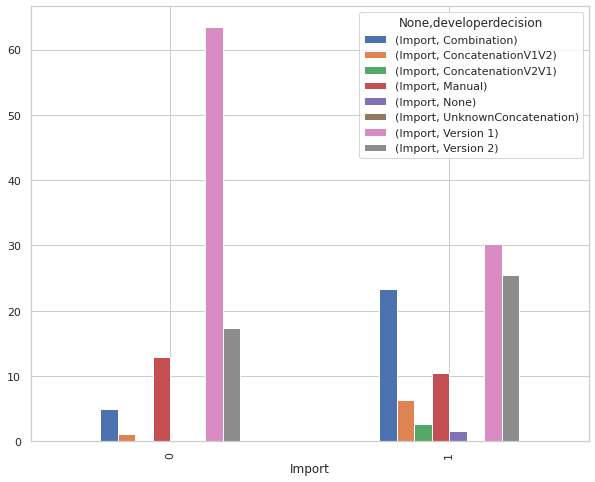

In [48]:
import_dist.unstack().plot(kind='bar', figsize=(10,8))

Distribution of classes on the whole dataset.

In [43]:
dataset_dist = selected_dataset_2[['Import', 'developerdecision']].groupby(['developerdecision']).count()\
  .apply(lambda x: x*100/x.sum())\
#   .sort_values(by=['Import'], ascending=False)
dataset_dist

,Import
developerdecision,
Combination,6.688922
ConcatenationV1V2,1.546824
ConcatenationV2V1,0.485895
Manual,12.629776
None,0.232461
UnknownConcatenation,0.001748
Version 1,60.257979
Version 2,18.156395


<AxesSubplot:xlabel='developerdecision'>

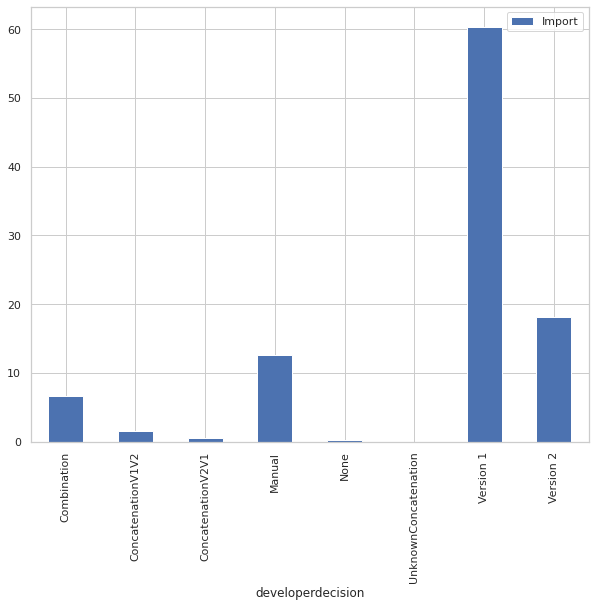

In [49]:
dataset_dist.plot(kind='bar', figsize=(10,8))

In [50]:
selected_dataset_2.columns

Index(['chunk_id', 'developerdecision', 'line_start', 'line_end',
       'line_separator', 'kind_conflict', 'url', 'project', 'project_user',
       'project_name', 'path', 'file_name', 'sha', 'leftsha', 'rightsha',
       'basesha', 'left_lines_added', 'left_lines_removed',
       'right_lines_added', 'right_lines_removed', 'conclusion_delay',
       'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve',
       'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add',
       'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change',
       'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkRelSize',
       'chunkPosition', 'fileSize', 'chunk_left_abs_size',
       'chunk_left_rel_size', 'chunk_right_abs_size', 'chunk_right_rel_size',
       'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2',
       'Different devs', 'Same devs', 'Devs intersection', 'Commits 1',
       'Commits 2', 'Changed files 1', 'Changed files 2',
       'Changed 

In [51]:
all_constructors = ['Class declaration', 'Return statement', 'Array access', 'Cast expression', 
                            'Attribute', 'Array initializer', 'Do statement', 'Case statement', 'Other', 'Method signature', 'Break statement',
                            'TypeDeclarationStatement', 'Comment', 'Method invocation', 'Package declaration', 'While statement', 
                            'Interface signature', 'Variable', 'Enum value', 'Class signature', 'Annotation', 'Method interface',
                            'Interface declaration', 'Synchronized statement', 'Throw statement', 'Switch statement', 'Catch clause',
                            'Try statement', 'Annotation declaration', 'For statement', 'Enum declaration', 'Enum signature', 'Assert statement',
                            'Static initializer', 'If statement', 'Method declaration', 'Continue statement', 'Import', 'Blank']

In [52]:
selected_dataset_2[all_constructors]

,Class declaration,Return statement,Array access,Cast expression,Attribute,Array initializer,Do statement,Case statement,Other,Method signature,...,For statement,Enum declaration,Enum signature,Assert statement,Static initializer,If statement,Method declaration,Continue statement,Import,Blank
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57210,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
57212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
constructs_freq = selected_dataset_2[all_constructors].apply(lambda s: s.value_counts(normalize=True)*100).T\
  .sort_values(by=[1], ascending=False)
constructs_freq

,0,1
Method invocation,60.364596,39.635404
Comment,63.942392,36.057608
If statement,80.385920,19.614080
Variable,81.453840,18.546160
Attribute,84.024889,15.975111
Method signature,89.394204,10.605796
Import,90.407942,9.592058
Method declaration,92.255392,7.744608
Annotation,94.599224,5.400776
Return statement,95.212710,4.787290


In [54]:
constructs_top10.set_index('Language construct')\
  .join(constructs_freq)\
  .drop(columns=[0])\
  .rename(columns={1:'Frequency %'})

,Avg. Information gain,Avg. Rank,Frequency %
Language construct,,,
Import,0.06,33.85,9.592058
Method invocation,0.03,42.00,39.635404
Variable,0.03,40.25,18.546160
Comment,0.03,50.25,36.057608
Blank,0.02,65.80,1.625476
Method signature,0.02,50.00,10.605796
Annotation,0.02,61.20,5.400776
If statement,0.02,47.25,19.614080
Attribute,0.01,53.55,15.975111


# Language construct top-1 per project

In [55]:
constructs_per_project = pd.read_csv('../../data/results/constructs_importance_projects.csv')
def fix_project_name(project_name):
    return project_name.replace('__','/')
constructs_per_project['project'] = constructs_per_project['project'].apply(fix_project_name)
constructs_per_project['project'] = constructs_per_project['project'].apply(get_new_project_name)
constructs_per_project = reorder_projects(table_with_stats, constructs_per_project).reset_index(drop=True)
constructs_per_project['information_gain'] = constructs_per_project['information_gain'].round(3)
data_rows = constructs_per_project.iloc[:-1 , :]\
  .sort_values(by=['information_gain'], ascending=False)
overall_row = constructs_per_project.iloc[-1: , :]
constructs_per_project = pd.concat([data_rows, overall_row])
constructs_per_project

,project,construct,information_gain,rank
4,apache/directory-server,Blank,0.216,29.0
16,TeamDev-Archive/OpenFaces,Comment,0.190,9.0
12,hibernate/hibernate-orm,Import,0.185,18.0
10,freenet/fred,Annotation,0.145,27.0
0,alexo/wro4j,Import,0.125,1.0
3,apache/accumulo,Import,0.110,25.0
9,eucalyptus/eucalyptus,Import,0.094,21.0
8,CloudStack-extras/CloudStack-archive,Blank,0.093,35.0
19,zkoss/zk,Method invocation,0.093,34.0
11,getrailo/railo,Import,0.080,35.0


In [56]:
# def fix_big_construct_name(construct_name):
#     if construct_name == 'Method invocation':
#         part1 = construct_name.split()[0]
#         part2 = construct_name.split()[1]
#         return "\\begin{tabular}[l]{@{}c@{}}" + part1 + "\\\\" + part2 + "\end{tabular}"
#     return construct_name
# constructs_per_project['construct'] = constructs_per_project['construct'].apply(fix_big_construct_name)
# constructs_per_project

In [57]:
constructs = constructs_per_project.rename(columns={'project':'Project',
                                       'construct':'Construct',
                                       'information_gain':'Information gain',
                                       'rank': 'Rank'})

constructs['Rank'] = constructs['Rank'].astype(int)

print(constructs.to_latex(index=False,
                          float_format="{:,.2f}".format,
                          column_format="p{5cm}p{3cm}p{2cm}p{1cm}"))

\begin{tabular}{p{5cm}p{3cm}p{2cm}p{1cm}}
\toprule
                              Project &           Construct &  Information gain &  Rank \\
\midrule
              apache/directory-server &               Blank &              0.22 &    29 \\
            TeamDev-Archive/OpenFaces &             Comment &              0.19 &     9 \\
              hibernate/hibernate-orm &              Import &              0.18 &    18 \\
                         freenet/fred &          Annotation &              0.14 &    27 \\
                          alexo/wro4j &              Import &              0.12 &     1 \\
                      apache/accumulo &              Import &              0.11 &    25 \\
                eucalyptus/eucalyptus &              Import &              0.09 &    21 \\
 CloudStack-extras/CloudStack-archive &               Blank &              0.09 &    35 \\
                             zkoss/zk &   Method invocation &              0.09 &    34 \\
                       getrail

# Developers importance per project

In [58]:
developers_per_project = pd.read_csv('../../data/results/developers_importance.csv')
developers_per_project['project'] = developers_per_project['project'].apply(fix_project_name)
developers_per_project['project'] = developers_per_project['project'].apply(get_new_project_name)
developers_per_project = reorder_projects(table_with_stats, developers_per_project).reset_index(drop=True)
developers_per_project['information_gain'] = developers_per_project['information_gain'].round(3)
developers_per_project = developers_per_project.drop('author', axis=1)
developers_per_project['rank'] = developers_per_project['rank'].astype(int)
data_rows = developers_per_project.iloc[:-1 , :]\
  .sort_values(by=['information_gain'], ascending=False)
overall_row = developers_per_project.iloc[-1: , :]
developers_per_project = pd.concat([data_rows, overall_row])
developers_per_project

,project,information_gain,rank
7,CCI-MIT/XCoLab,0.547,23
4,apache/directory-server,0.216,30
14,Ramblurr/Anki-Android,0.176,29
10,freenet/fred,0.122,29
3,apache/accumulo,0.108,26
8,CloudStack-extras/CloudStack-archive,0.099,34
5,apache/lucene-solr,0.096,23
11,getrailo/railo,0.092,31
12,hibernate/hibernate-orm,0.087,27
19,zkoss/zk,0.083,37


In [59]:
print(developers_per_project.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                              project &  information\_gain &  rank \\
\midrule
                       CCI-MIT/XCoLab &             0.547 &    23 \\
              apache/directory-server &             0.216 &    30 \\
                Ramblurr/Anki-Android &             0.176 &    29 \\
                         freenet/fred &             0.122 &    29 \\
                      apache/accumulo &             0.108 &    26 \\
 CloudStack-extras/CloudStack-archive &             0.099 &    34 \\
                   apache/lucene-solr &             0.096 &    23 \\
                       getrailo/railo &             0.092 &    31 \\
              hibernate/hibernate-orm &             0.087 &    27 \\
                             zkoss/zk &             0.083 &    37 \\
                      Unidata/thredds &             0.077 &    27 \\
                 alkacon/opencms-core &             0.074 &    22 \\
                      jgralab/jgralab &             0.074 &    